In [1]:
# Import necessary libraries for managing datasets, image processing, and modeling.

# Datasets and XML parsing
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import h5py

# Image preprocessing
from skimage import feature
import skimage
from sklearn.feature_extraction.image import extract_patches_2d
from PIL import Image, ImageFilter, ImageEnhance, ImageDraw, ImageFont
import imgaug.augmenters as iaa
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize, pyramid_gaussian

#Generic libraries
import numpy as np
import matplotlib.pyplot as plt
import argparse
import random
import os

# Model & Training
from sklearn.svm import SVC
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

#### Here we define some paths to jpeg and xml files

*for generate xml with all information about class and boxes coordinates LabelImg where used*

In [2]:
all_jpeg = glob.glob('cumulative_jpeg/'+'*.jpeg')
all_xml = glob.glob('cumulative_xml/'+'*.xml')
not_faces = glob.glob('negative_jpeg/'+'*.jpeg')

In [3]:
# Iterate through all XML files and build a tree object for each one.
# The last tree object in the loop will be the one retained.
for t in all_xml:
    tree = ET.parse(t)

# Get the root element of the tree, which represents the top-level element in the XML file.
root = tree.getroot()

# Print the XML tree (this will display the tree's root element and its structure).
print(tree)

# Initialize an empty list to store the tags present in the XML files.
child_tags = []

# Iterate through the children of the root element and extract their tag names.
# Append these tag names to the child_tags list.
for child in root:
    childtag = child.tag
    child_tags.append(childtag)

# Print the list of extracted child tags from the XML files.
print(child_tags)

['folder', 'filename', 'path', 'source', 'size', 'segmented', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object', 'object']


In [4]:
# Iterate through the elements within the "size" tag.
# This tag often contains information about the width and height of the images.
for s in root.find('size'):
    # Print the individual elements within the "size" tag.
    print(s)

<Element 'width' at 0x12a07fa40>
<Element 'height' at 0x12a07f8b0>
<Element 'depth' at 0x12a07fc70>


#### With this code we can extract bouding boxes coordinates from the xml files

In [5]:
def extract_bounding_boxes(xml_files):
    bounding_boxes = []

    for t in xml_files:
        tree = ET.parse(t)
        root = tree.getroot()

        for obj in root.findall('object'):
            name = obj.find('name').text
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            bounding_box_info = {'name': name, 'xmin': xmin,
                                 'ymin': ymin, 'xmax': xmax,
                                 'ymax': ymax}
            bounding_boxes.append(bounding_box_info)

    return bounding_boxes

# Call the function with list of XML files
bounding_boxes = extract_bounding_boxes(all_xml)

# Print the extracted bounding box information as an example to show how it works
for index, box in enumerate(bounding_boxes[:2], start=1):
    print(f"Bounding Box {index} - Object: {box['name']}")
    print(f"xmin: {box['xmin']}, ymin: {box['ymin']}, xmax: {box['xmax']}, ymax: {box['ymax']}")

Bounding Box 1 - Object: face
xmin: 15, ymin: 14, xmax: 79, ymax: 72
Bounding Box 2 - Object: face
xmin: 55, ymin: 55, xmax: 98, ymax: 108


##### Here we generate a dataframe with the most important information

In [6]:
def df_from_xml(xml_path):
    """
    Generates a DataFrame from XML files containing object and bounding box information.

    Args:
        xml_path (str): Path to the directory containing XML files.

    Returns:
        pd.DataFrame: DataFrame containing object and bounding box information.
    """

    xml_list = []
    # Iterate through XML files in the specified directory
    for x_file in all_xml:
        tree = ET.parse(x_file)
        root = tree.getroot()
        filename = root.find('filename').text
        width = int(root.find('size').find('width').text)
        height = int(root.find('size').find('height').text)

        # Iterate through bounding boxes in the XML file
        for bb in root.findall('object'):
            bndbox = bb.find('bndbox')
            value = (
                filename,
                width,
                height,
                bb.find('name').text,
                int(bndbox.find('xmin').text),
                int(bndbox.find('ymin').text),
                int(bndbox.find('xmax').text),
                int(bndbox.find('ymax').text)
            )
            xml_list.append(value)

    # Create a DataFrame from the collected information
    column_names = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    dataset = pd.DataFrame(xml_list, columns=column_names)
    return dataset

#### A little bit of exploration of the dataset

In [7]:
dataset = df_from_xml(all_xml)

In [8]:
dataset.to_csv('faces.csv',index=False)

In [9]:
dataset['class'].value_counts()

class
face    242
Name: count, dtype: int64

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  242 non-null    object
 1   width     242 non-null    int64 
 2   height    242 non-null    int64 
 3   class     242 non-null    object
 4   xmin      242 non-null    int64 
 5   ymin      242 non-null    int64 
 6   xmax      242 non-null    int64 
 7   ymax      242 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.2+ KB


In [11]:
dataset.describe()

,width,height,xmin,ymin,xmax,ymax
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,259.318182,181.033058,109.574380,56.016529,149.132231,98.128099
std,76.906704,43.535827,68.676376,41.890290,79.294916,53.956992
min,100.000000,100.000000,1.000000,3.000000,18.000000,20.000000
25%,225.000000,168.000000,59.000000,25.500000,88.000000,61.000000
50%,275.000000,181.000000,101.000000,48.000000,146.000000,88.000000
75%,300.000000,194.000000,154.250000,65.000000,201.000000,130.750000
max,1024.000000,575.000000,386.000000,225.000000,704.000000,575.000000


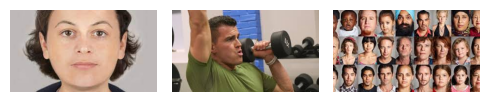

In [12]:

num_images = 3  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(5, 5))

# Iterate through a subset of image files (adjust the range as needed)
for i, img_path in enumerate(all_jpeg[:num_images]):
    # Read the image using imread
    img = imread(img_path)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(img)
    axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

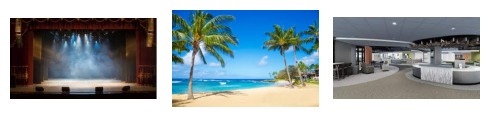

In [13]:
num_images = 3  # Number of images to display
fig, axes = plt.subplots(1, num_images, figsize=(5, 5))

# Iterate through a subset of image files (adjust the range as needed)
for i, img_path in enumerate(not_faces[:num_images]):
    # Read the image using imread
    img = imread(img_path)
    
    # Display the image in the corresponding subplot
    axes[i].imshow(img)
    axes[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Using the mean of the x and y of bounding boxes we can get a good approximation for a possible sliding window dimension.
*Ceil function is used to round up to the first integer*

In [14]:
# Calculate the average width and height of bounding boxes labeled as "face" in the dataset
# This can be used as a window sliding dimension for face detection
xdim = np.ceil(np.mean(dataset[dataset['class'] == 'face']['xmax'] - dataset[dataset['class'] == 'face']['xmin']))
ydim = np.ceil(np.mean(dataset[dataset['class'] == 'face']['ymax'] - dataset[dataset['class'] == 'face']['ymin']))

In [15]:
print(xdim,ydim)

40.0 43.0


#### Here start the functions used to manipulate images

In [16]:
def hogFeatures(image, orientations = 12, pixelsPerCell = (8,8), cellsPerBlock = (2,2), channel_axis=-1):
    """
    Extract HOG features from an image and set negative values to 0.

    Args:
        image (ndarray): The input image.
        orientations (int): Number of bins in the histogram.
        pixelsPerCell (tuple): Number of pixels per cell.
        cellsPerBlock (tuple): Number of cells per block.
        channel_axis (int, optional): Axis representing color channels.

    Returns:
        ndarray: Extracted HOG features.
    """
    # Extract HOG features from the image
    features = feature.hog(image,
                           orientations=orientations,
                           pixels_per_cell=pixelsPerCell,
                           cells_per_block=cellsPerBlock,
                           transform_sqrt=True,
                           channel_axis=channel_axis)
    
    # Set any negative values to 0
    features[features < 0] = 0
    
    return features

In [17]:
def img_aug(roi, width, height, extension=True):
    """
    Perform image augmentation on a region of interest (ROI).

    Args:
        roi (PIL.Image): The region of interest image.
        width (int): The target width after resizing.
        height (int): The target height after resizing.
        extension (bool, optional): Flag indicating whether to apply extended augmentation.

    Returns:
        list: List of augmented region of interest images.
    """
    region_interests = []

    # Resize the ROI image to the specified width and height
    roi_resized = roi.copy().resize((width, height), Image.BICUBIC)
    region_interests.append(roi_resized)

    if extension:
        # Apply rotations and filters for augmentation
        transformations = [30, 60, 90, 120, 150]
        for transf in transformations:
            rotation = roi_resized.rotate(transf)
            region_interests.append(rotation)

        sharpness = ImageEnhance.Sharpness(roi_resized)
        contrast = ImageEnhance.Contrast(roi_resized)

        # Additional augmentation transformations
        region_interests.append(roi_resized.filter(ImageFilter.EDGE_ENHANCE))
        region_interests.append(sharpness.enhance(5))
        region_interests.append(contrast.enhance(5.0))

    return region_interests

In [18]:
test_img = Image.open('cumulative_jpeg/'+dataset['filename'][0])
test = img_aug(test_img,40,43)
test

[<PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>,
 <PIL.Image.Image image mode=RGB size=40x43>]

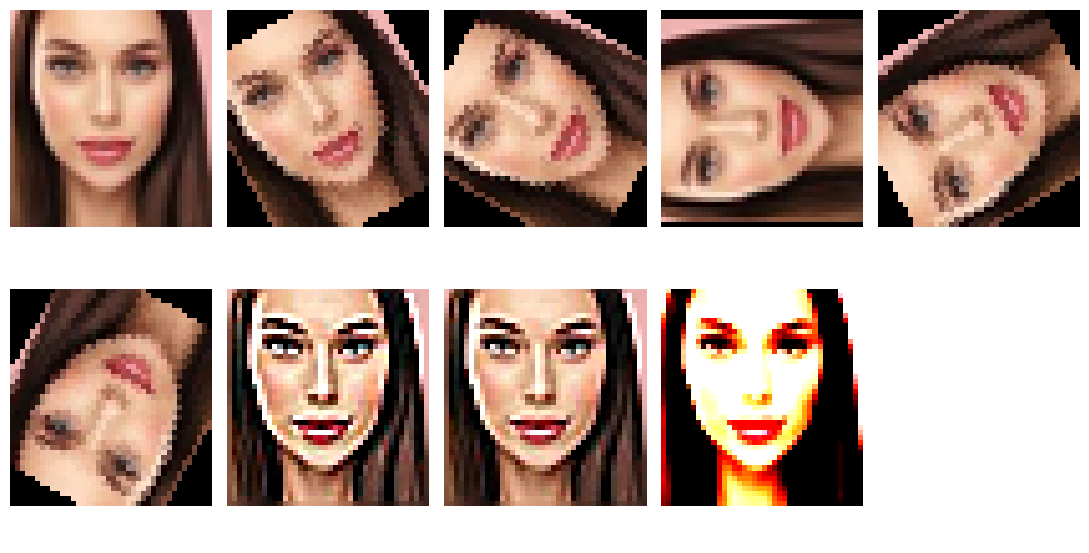

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(11,6))

for i, ax in enumerate(axes.flatten()):
    if i < len(test):
        ax.imshow(test[i])
        ax.axis('off')
    else:
        ax.axis('off')  # Turn off unused subplots

# Add this line to ensure proper spacing between subplots
plt.tight_layout()

plt.show()

In [20]:
def Ex_region_of_interest(row, path):
    """
    Extracts a region of interest (ROI) from an image based on bounding box information,
    applies image augmentation, and returns a list of augmented ROIs.

    Args:
        row (pd.Series): A row containing bounding box information.
        path (str): Path to the directory containing the images.

    Returns:
        list: List of augmented ROIs.
    """
    # Open the image using the provided path
    img = Image.open(os.path.join(path, row['filename']))
    
    # Get the bounding box coordinates
    bounding_boxes = [int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])]
    
    # Crop the region of interest (ROI) from the image
    roi = img.crop(bounding_boxes)

    # Get a list of augmented images using img_aug (please provide details about img_aug)
    augmented_rois = []
    rois = img_aug(roi, 40, 43)  # You might want to explain what img_aug does
    
    for roi in rois:
        augmented_rois.append(roi)
    
    return augmented_rois

In [21]:
def featExtractor(rois, data, labels, positive=True, orientations = 12,
                   pixelsPerCell = (8,8), cellsPerBlock = (2,2)):
    """
    Extracts HOG features from a list of ROIs and appends features and labels to data and labels lists.

    Args:
        rois (list): List of regions of interest (ROIs).
        data (list): List to store feature data.
        labels (list): List to store labels.
        positive (bool, optional): Flag indicating if the ROIs are positive samples.

    Returns:
        tuple: Updated data and labels lists.
    """
    for roi in rois:
        # Extract HOG features from the ROI
        features = hogFeatures(roi, orientations, pixelsPerCell, cellsPerBlock)
        
        # Append features and labels to corresponding lists
        data.append(features)
        labels.append(int(1))  # Positive label
        
    return data, labels

#### Here we create a dataset containing all features extracted and labels, is on this that our model will be trained

In [22]:
def process_dataset(dataset, path, orientations = 12, pixelsPerCell = (8,8), cellsPerBlock = (2,2)):
    
    """
    Process a dataset for feature extraction and label creation.

    Parameters:
        dataset (pandas.DataFrame): DataFrame containing dataset information.
        path (str): Path to the dataset images.
        orientations (int, optional): Number of gradient orientations for HOG feature extraction.
        pixelsPerCell (tuple, optional): Number of pixels per cell for HOG feature extraction.
        cellsPerBlock (tuple, optional): Number of cells per block for HOG feature extraction.

    Returns:
        data (list): List of extracted features.
        labels (list): Corresponding labels for the extracted features.
    """
    
    data = []
    labels = []
    augmented_rois = []
    positive_labels = []

    for idx, row in dataset.iterrows():
        if row['class'] == 'face':
            rois = Ex_region_of_interest(row, path)
            augmented_rois.extend(rois)
            positive_labels.extend([1] * len(rois))

    # Process positive samples
    data, labels = featExtractor(augmented_rois, data, labels, positive=True)

    # Process negative samples
    for row in not_faces:
        img = Image.open(row)
        image = np.array(img)
        patches = extract_patches_2d(image, (40, 43), max_patches=25)
        
        for patch in patches:
            patch_img = Image.fromarray(patch)
            augmented_patches = img_aug(patch_img, 40, 43, extension=False)
            
            for augmented_patch in augmented_patches:
                features = hogFeatures(augmented_patch, orientations, pixelsPerCell, cellsPerBlock, channel_axis=-1)
                data.append(features)
                labels.append(0)

    return data, labels

In [23]:
data,labels = process_dataset(dataset,'cumulative_jpeg')

In [24]:
def create_hdf5_database(output_path, data, labels):
    
    """
    Create an HDF5 database file containing features and labels.

    This function creates an HDF5 database file to store a dataset's features and corresponding labels.
    The features and labels are combined into a single dataset within the HDF5 file.

    Parameters:
        output_path (str): Path to the output HDF5 file.
        data (list or np.ndarray): List or array of feature vectors.
        labels (list or np.ndarray): List or array of corresponding labels.

    Returns:
        labels (np.ndarray): Array of labels extracted from the HDF5 database.
        data (np.ndarray): Array of features extracted from the HDF5 database.
    """
    
    db = h5py.File(output_path, "w")
    dataset = db.create_dataset('dataset_features_all', (len(data), len(data[0]) + 1), dtype="float")
    combined_data = np.c_[labels, data]
    dataset[0:len(data)] = combined_data
    
    labels = db['dataset_features_all'][:, 0]  # Get the first column (labels)
    data = db['dataset_features_all'][:, 1:]    # Get all columns except the first (features)
    
    db.close()
    return labels,data

In [25]:
current_directory = os.getcwd()

# Define the filename and create the full output path
filename = 'dataset_features_all.hdf5'
output_path = os.path.join(current_directory, filename)

In [26]:
labels,data = create_hdf5_database(output_path, data, labels)

In [27]:
print("Labels shape:", labels.shape)
print("Data shape:", data.shape)

Labels shape: (4128,)
Data shape: (4128, 768)


#### Now start the training part

*using MinMaxScaler make randomized search and model training more faster (when i tried randomized search without scaling, after 10 minutes where not finished)*

In [28]:
MMS = MinMaxScaler()

In [29]:
data_scaled = MMS.fit_transform(data)

In [30]:
param_dist = {
    'C': uniform(loc=0, scale=100),  # Uniform distribution from 0 to 100
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': uniform(loc=1e-3, scale=1e3)  # Uniform distribution from 0.001 to 1000
}

# Create SVM classifier
svc = SVC(probability=True)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(svc,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=2,
                                   random_state=8986)

random_search.fit(data_scaled, labels)

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

# Evaluate the best model on the test set
best_model = random_search.best_estimator_

Best hyperparameters: {'C': 86.40920303439337, 'gamma': 671.7587340615771, 'kernel': 'poly'}


### FUNCTIONS FOR FACE DETECTION:

In [31]:
def image_reader(path):
    
    """
    Read an image from the specified path and convert it to a NumPy array.

    Parameters:
        path (str): Path to the image file.

    Returns:
        np.ndarray: NumPy array representing the image.
    """
    image = Image.open(path)
    return np.array(image)

In [32]:
def sliding_window(image, step_size, window_size = (40,43)):
    """
    Generate sliding window patches from an image.

    Args:
        image (ndarray): The input image.
        step_size (int): The step size for sliding the window.
        window_size (tuple): The size of the sliding window (width, height).

    Yields:
        ndarray: Patches extracted using the sliding window.
    """
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            # Yield the current patch
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [33]:
def detect_faces(image, model, windowSize=(40, 43), threshold=0.98,ratio = 0.2):
    
    """
    Detect faces in an image using a sliding window approach and a trained model.

    Parameters:
        image (np.ndarray): Input image as a NumPy array.
        model (sklearn.base.BaseEstimator): Trained model for face detection.
        windowSize (tuple, optional): Size of the sliding window for detection (width, height).
        threshold (float, optional): Minimum probability threshold for face detection.
        ratio (float, optional): Scaling factor between consecutive image pyramid layers.

    Returns:
        list: List of detected bounding boxes [(startX, startY, endX, endY), ...].
        list: List of probabilities corresponding to each detected bounding box.
    """
    
    gray = rgb2gray(image)
    
    boxes = []
    probs = []
    
    for (i, layer) in enumerate(pyramid_gaussian(image, downscale=1.2)):
        # Identify the current scale of the image
        scale = gray.shape[0] / float(layer.shape[0])
        step_size = int(windowSize[0] * ratio)
    
        # Loop over the sliding window for each layer of the pyramid
        for (x, y, window) in sliding_window(layer, step_size=step_size):
            # If the current window does not meet our desired window size, ignore it
            if window.shape[0] != windowSize[1] or window.shape[1] != windowSize[0]:
                continue
            
            # Extract HOG features of this window
            feat = hogFeatures(window, channel_axis=-1).reshape(1, -1)
            feat_scaled = MMS.transform(feat)
            # Get the prediction probabilities for the positive class
            prob = best_model.predict_proba(feat_scaled)[0][1]
            
            # Check if the probability is greater than the threshold
            if prob >= threshold:
                # Extract (x, y)-coordinates of the bounding box using the current scale
                (startX, startY) = (int(scale * x), int(scale * y))
                endX = int(startX + (scale * windowSize[0]))
                endY = int(startY + (scale * windowSize[1]))
                
                # Update the list of bounding boxes and probabilities
                boxes.append((startX, startY, endX, endY))
                probs.append(prob)
                
    return boxes, probs
    

In [34]:
def draw_full_bounding_boxes(image, boxes):
    """
    Draw bounding boxes on the given image.

    Args:
        image (numpy.ndarray): The input image as a NumPy array.
        boxes (list): A list of tuples containing bounding box coordinates (startX, startY, endX, endY).

    Returns:
        None
    """
    copy = Image.fromarray(image).copy()
    draw = ImageDraw.Draw(copy)
    for (startX, startY, endX, endY) in boxes:
        outline_color = (0, 255, 255)  # Blue color
        line_width = 1
        draw.rectangle([(startX, startY), (endX, endY)], outline=outline_color, width=line_width)

    plt.title('BOXES DETECTED')
    plt.imshow(copy, aspect='equal')
    plt.axis('off')
    plt.show()

# Usage example:
# image = ...  # Load or create your image as a numpy.ndarray
# boxes = [(startX1, startY1, endX1, endY1), (startX2, startY2, endX2, endY2), ...]
# draw_bounding_boxes(image, boxes)

In [35]:
def maxOverlap(boxes, threshold = .2):
    '''
    boxes : This is the coordinates of the boxes which have the object
    returns : A list of boxes which do not have much overlap
    '''
    # Convert the bounding boxes into an array
    boxes = np.array(boxes)
    # Initialize a list to pick the IDs of the selected boxes and include the largest box
    selected = []
    
    # Continue the loop until the number of boxes remaining is greater than 1
    while len(boxes) > 1:
        # First calculate the area of the bounding boxes 
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        area = (x2 - x1) * (y2 - y1)
        
        # Sort the bounding boxes based on their area
        ids = np.argsort(area)
        
        # Take the coordinates of the box with the largest area
        lx1 = boxes[ids[-1], 0]
        ly1 = boxes[ids[-1], 1]
        lx2 = boxes[ids[-1], 2]
        ly2 = boxes[ids[-1], 3]
        
        # Include the largest box into the selected list
        selected.append(boxes[ids[-1]].tolist())
        
        # Initialize a list for storing IDs that need to be removed
        remove = []
        remove.append(ids[-1])
        
        # Loop through each of the other boxes and find the overlap with the largest box
        for id in ids[:-1]:
            # Calculate overlap coordinates
            ox1 = np.maximum(lx1, boxes[id, 0])
            oy1 = np.maximum(ly1, boxes[id, 1])
            ox2 = np.minimum(lx2, boxes[id, 2])
            oy2 = np.minimum(ly2, boxes[id, 3])
            
            # Calculate the area of the overlapping region
            oa = (ox2 - ox1) * (oy2 - oy1)
            
            # Calculate the ratio of overlapping area with respect to the smaller box's area
            olRatio = oa / area[id]
            
            # If the overlap is greater than the threshold, include the ID in the remove list
            if olRatio > threshold:
                remove.append(id)
                
        # Remove the IDs from the original boxes
        boxes = np.delete(boxes, remove, axis=0)
        
        # Break the loop if nothing to remove
        if len(remove) == 0:
            break
            
    # Append the remaining boxes to the selected list
    for i in range(len(boxes)):
        selected.append(boxes[i].tolist())
        
    return np.array(selected)


In [36]:
def draw_bounding_boxes(image, selected, probs):
    # Make a copy of the image
    clone = Image.fromarray(image).copy()

    # Create a draw object for drawing on the image
    draw = ImageDraw.Draw(clone)

    # Loop over each selected bounding box and its associated probability
    for (startX, startY, endX, endY), probability in zip(selected, probs):
        # Define the outline color for the bounding box (green)
        outline_color = (255, 255, 0)

        # Define the line width for the bounding box
        line_width = 1

        # Draw the bounding box on the image
        draw.rectangle([(startX, startY), (endX, endY)], outline=outline_color, width=line_width)

        # Calculate the position for the probability text
        text_x = startX
        text_y = startY  # Adjust this value to control the vertical placement of the text

        # Add the probability as text inside the bounding box
        draw.text((text_x, text_y), f'{probability:.2f}', fill=outline_color)

    # Display the image with bounding boxes and probabilities
    plt.title('REMAINING BOXES AFTER SUPPRESSION')
    plt.imshow(clone, aspect='equal')
    plt.axis('off')
    plt.show()

In [37]:
test_set = glob.glob('test_set/' + '/*.jpeg')

In [38]:
image = image_reader(test_set[-1])

In [39]:
boxes,probs = detect_faces(image,best_model)
selected = maxOverlap(boxes)

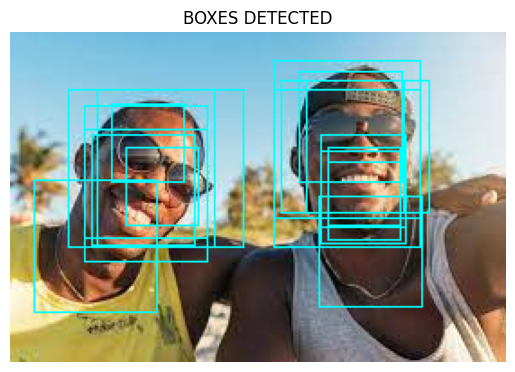

In [40]:
draw_full_bounding_boxes(image,boxes)

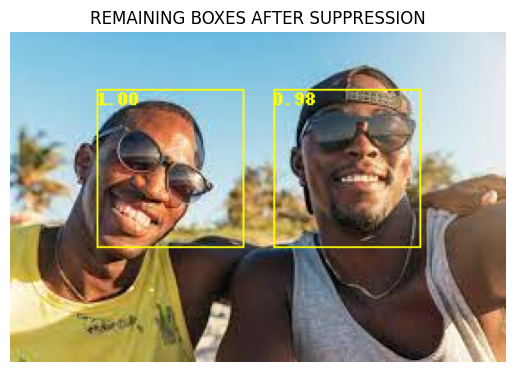

In [41]:
draw_bounding_boxes(image,selected,probs)

# Make pipeline

In [42]:
from sklearn.base import BaseEstimator,TransformerMixin

In [43]:
class FaceDetector(BaseEstimator,TransformerMixin):
    
    def __init__(self,best_model,window_size = (40,43),factor_ratio = .2,
                 overlap_threshold = .2,
                 proba_threshold = .98,
                 downscale = 1.2):
        
        self.window_size = window_size
        self.factor_ratio = factor_ratio
        self.overlap_threshold = overlap_threshold
        self.proba_threshold = proba_threshold
        self.downscale = downscale
        self.best_model = best_model
        
    def fit( self, X, y = None):
        return self
        
    def image_reader(self,path):
    
        """
        Read an image from the specified path and convert it to a NumPy array.

        Parameters:
            path (str): Path to the image file.

        Returns:
            np.ndarray: NumPy array representing the image.
        """
        image = Image.open(path)
        return np.array(image)
        
    def sliding_window(self,image, step_size):
        """
        Generate sliding window patches from an image.

        Args:
            image (ndarray): The input image.
            step_size (int): The step size for sliding the window.
            window_size (tuple): The size of the sliding window (width, height).

        Yields:
            ndarray: Patches extracted using the sliding window.
        """
        for y in range(0, image.shape[0], step_size):
            for x in range(0, image.shape[1], step_size):
                # Yield the current patch
                yield (x, y, image[y:y + self.window_size[1], x:x + self.window_size[0]])
        
    def detect_faces(self,image,best_model):
    
        """
        Detect faces in an image using a sliding window approach and a trained model.

        Parameters:
            image (np.ndarray): Input image as a NumPy array.
            model (sklearn.base.BaseEstimator): Trained model for face detection.
            windowSize (tuple, optional): Size of the sliding window for detection (width, height).
            threshold (float, optional): Minimum probability threshold for face detection.
            ratio (float, optional): Scaling factor between consecutive image pyramid layers.

        Returns:
            list: List of detected bounding boxes [(startX, startY, endX, endY), ...].
            list: List of probabilities corresponding to each detected bounding box.
        """
        
        gray = rgb2gray(image)
        
        boxes = []
        probs = []
        
        for (i, layer) in enumerate(pyramid_gaussian(image, downscale= self.downscale)):
            # Identify the current scale of the image
            scale = gray.shape[0] / float(layer.shape[0])
            step_size = int(self.window_size[0] * self.factor_ratio)
        
            # Loop over the sliding window for each layer of the pyramid
            for (x, y, window) in self.sliding_window(layer, step_size=step_size):
                # If the current window does not meet our desired window size, ignore it
                if window.shape[0] != self.window_size[1] or window.shape[1] != self.window_size[0]:
                    continue
                
                # Extract HOG features of this window
                features = hogFeatures(window, channel_axis=-1).reshape(1, -1)
                feat_scaled = MMS.transform(features)
                # Get the prediction probabilities for the positive class
                prob = self.best_model.predict_proba(feat_scaled)[0][1]
                
                # Check if the probability is greater than the threshold
                if prob >= self.proba_threshold:
                    # Extract (x, y)-coordinates of the bounding box using the current scale
                    (startX, startY) = (int(scale * x), int(scale * y))
                    endX = int(startX + (scale * self.window_size[0]))
                    endY = int(startY + (scale * self.window_size[1]))
                    
                    # Update the list of bounding boxes and probabilities
                    boxes.append((startX, startY, endX, endY))
                    probs.append(prob)
                    
        return boxes, probs
            
    def maxOverlap(self,boxes):
        '''
        boxes : This is the coordinates of the boxes which have the object
        returns : A list of boxes which do not have much overlap
        '''
        # Convert the bounding boxes into an array
        boxes = np.array(boxes)
        # Initialize a list to pick the IDs of the selected boxes and include the largest box
        selected = []
        
        # Continue the loop until the number of boxes remaining is greater than 1
        while len(boxes) > 1:
            # First calculate the area of the bounding boxes 
            x1 = boxes[:, 0]
            y1 = boxes[:, 1]
            x2 = boxes[:, 2]
            y2 = boxes[:, 3]
            area = (x2 - x1) * (y2 - y1)
            
            # Sort the bounding boxes based on their area
            ids = np.argsort(area)
            
            # Take the coordinates of the box with the largest area
            lx1 = boxes[ids[-1], 0]
            ly1 = boxes[ids[-1], 1]
            lx2 = boxes[ids[-1], 2]
            ly2 = boxes[ids[-1], 3]
            
            # Include the largest box into the selected list
            selected.append(boxes[ids[-1]].tolist())
            
            # Initialize a list for storing IDs that need to be removed
            remove = []
            remove.append(ids[-1])
            
            # Loop through each of the other boxes and find the overlap with the largest box
            for id in ids[:-1]:
                # Calculate overlap coordinates
                ox1 = np.maximum(lx1, boxes[id, 0])
                oy1 = np.maximum(ly1, boxes[id, 1])
                ox2 = np.minimum(lx2, boxes[id, 2])
                oy2 = np.minimum(ly2, boxes[id, 3])
                
                # Calculate the area of the overlapping region
                oa = (ox2 - ox1) * (oy2 - oy1)
                
                # Calculate the ratio of overlapping area with respect to the smaller box's area
                olRatio = oa / area[id]
                
                # If the overlap is greater than the threshold, include the ID in the remove list
                if olRatio > self.overlap_threshold:
                    remove.append(id)
                    
            # Remove the IDs from the original boxes
            boxes = np.delete(boxes, remove, axis=0)
            
            # Break the loop if nothing to remove
            if len(remove) == 0:
                break
                
        # Append the remaining boxes to the selected list
        for i in range(len(boxes)):
            selected.append(boxes[i].tolist())
            
        return np.array(selected)
    

        # Display the image with bounding boxes and probabilities
    def transform(self, image_path):
        """
        Apply the face detection transformation to a single image.

        Parameters:
            image_path (str): Path to the input image.

        Returns:
            list: List of bounding box coordinates.
        """
        # Read the image
        image = self.image_reader(image_path)

        # Apply face detection
        boxes, probs = self.detect_faces(image,best_model)
        print(f'Here the list of bounding boxes BEFORE suppression:\n {boxes}')
        selected = self.maxOverlap(boxes)
        print(f'Here the list of bounding boxes AFTER suppression:\n {selected}')

In [44]:
path = test_set[-1]

In [45]:
face_recognizer = FaceDetector(best_model)

In [46]:
face_detection_pipeline = Pipeline([('face_detector',face_recognizer)])

In [47]:
output = face_detection_pipeline.transform(path)

Here the list of bounding boxes BEFORE suppression:
 [(56, 40, 96, 83), (64, 64, 104, 107), (176, 64, 216, 107), (176, 72, 216, 115), (172, 57, 219, 108), (172, 66, 219, 117), (160, 22, 217, 83), (45, 57, 102, 118), (171, 91, 228, 152), (150, 27, 218, 100), (164, 27, 232, 100), (41, 41, 109, 114), (41, 54, 109, 127), (13, 82, 81, 155), (146, 16, 227, 103), (32, 32, 113, 119), (48, 32, 129, 119), (146, 32, 227, 119)]
Here the list of bounding boxes AFTER suppression:
 [[146  32 227 119]
 [ 48  32 129 119]]
